In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
# --- 1. The Custom Dataset Class ---
class LaneDataset(Dataset):
    def __init__(self, annotations, transform=None):

        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.annotations[idx]['image']
        mask_path = self.annotations[idx]['mask']
        
        # PIL.Image is the standard way to open images for torchvision
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # "L" for grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Ensure mask is a binary tensor with values 0 or 1
        mask = torch.where(mask > 0, 1.0, 0.0)
            
        return image, mask


Loading annotations...
Total samples: 3626
Training samples: 2900
Validation samples: 726

Creating Datasets and DataLoaders...
Done.

Displaying one batch for visual verification...
Image batch shape: torch.Size([8, 3, 288, 512])
Mask batch shape: torch.Size([8, 1, 288, 512])


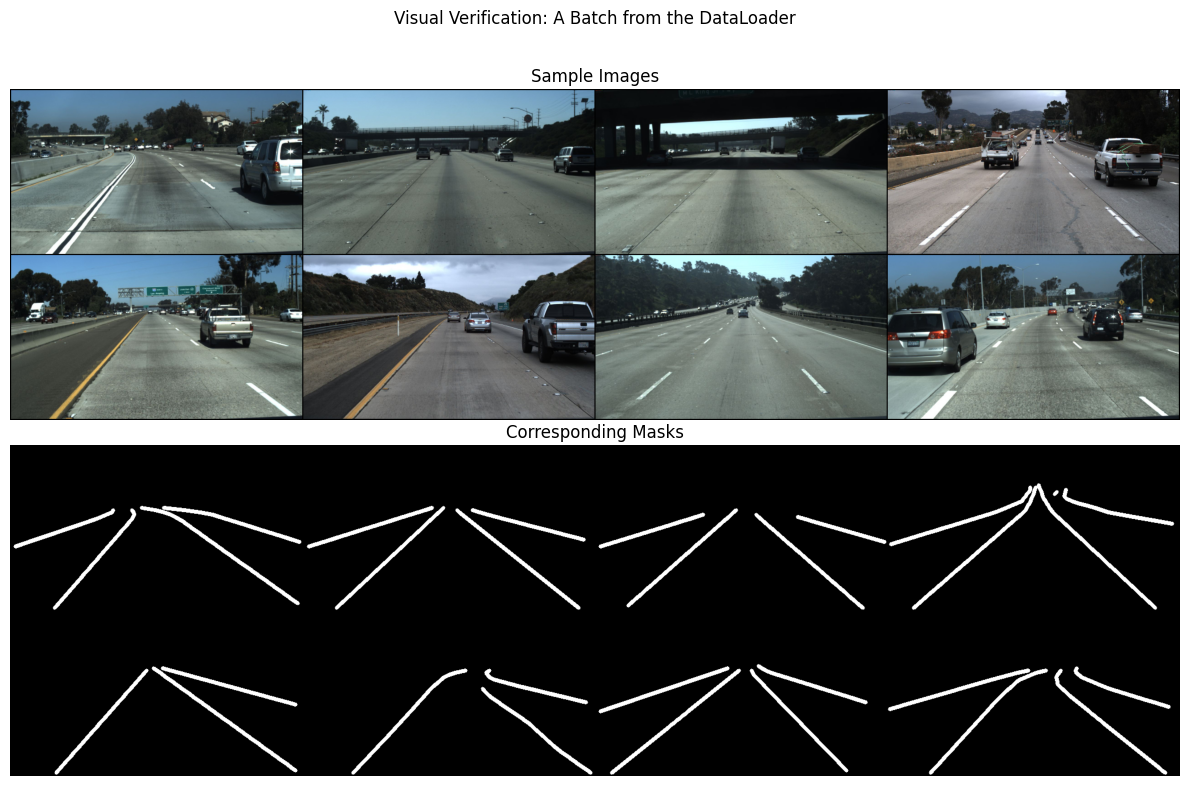

In [ ]:
if __name__ == "__main__":
    # Define file paths and parameters
    ANNOTATION_FILE = "processed/annotations.json"
    BATCH_SIZE = 8

    # --- Step 1: Load and Split the Data ---
    print("Loading annotations...")
    with open(ANNOTATION_FILE, "r") as f:
        all_annotations = json.load(f)

    # Use sklearn to split data into training (80%) and validation (20%) sets
    train_ann, val_ann = train_test_split(all_annotations, test_size=0.2, random_state=42)
    
    print(f"Total samples: {len(all_annotations)}")
    print(f"Training samples: {len(train_ann)}")
    print(f"Validation samples: {len(val_ann)}")

    # --- Step 2: Define Transformations ---
    # These transforms will be applied to every image and mask
    transform = transforms.Compose([
        transforms.ToTensor(), # Converts PIL Image to a PyTorch Tensor
    ])

    # --- Step 3: Create Datasets and DataLoaders ---
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = LaneDataset(annotations=train_ann, transform=transform)
    val_dataset = LaneDataset(annotations=val_ann, transform=transform)

    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True  # Shuffle training data
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False # No need to shuffle validation data
    )
    print("Done.")

    # --- Step 4: Visually Verify a Batch (CRUCIAL) ---
    print("\nDisplaying one batch for visual verification...")
    
    # Get one batch from the training loader
    images, masks = next(iter(train_loader))
    
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")

    # Create a grid to display images and masks
    img_grid = torchvision.utils.make_grid(images, nrow=4)
    mask_grid = torchvision.utils.make_grid(masks, nrow=4)
    
    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    fig.suptitle("Visual Verification: A Batch from the DataLoader")
    
    # Display Images
    ax[0].imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
    ax[0].set_title("Sample Images")
    ax[0].axis('off')
    
    # Display Masks
    # We need to handle the single channel for grayscale masks
    ax[1].imshow(np.transpose(mask_grid.numpy(), (1, 2, 0)), cmap='gray')
    ax[1].set_title("Corresponding Masks")
    ax[1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()